In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import brentq, least_squares
import matplotlib.pylab as plt
import math




In [2]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def preprocess_options_data(file_path):
    """
    Preprocess options data by calculating mid-price, scaling strike prices, 
    and mapping call/put flags.

    Parameters:
    - file_path (str): Path to the CSV file containing options data.

    Returns:
    - DataFrame: Processed options data with 'mid', 'strike', and 'payoff' columns.
    """
    df = pd.read_csv(file_path)
    df['mid'] = 0.5 * (df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price'] * 0.001  # Adjusting strike price scale
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def BachelierCall(S0, K, T, r, sig)->tuple:
    """
    Calculate the discounted Bachelier prices of European call options.
    """
    d = (S0 - K)/(sig*T**.5)
    
    return math.exp(-r*T) * ( (S0 - K)*norm.cdf( d) + sig*T**.5*norm.pdf( d))

def BachelierPut(S0, K, T, r, sig)->tuple:
    """
    Calculate the discounted Bachelier prices of European put options.
    """
    d = (S0 - K)/(sig*T**.5)
    
    return math.exp(-r*T) * (-(S0 - K)*norm.cdf(-d) + sig*T**.5*norm.pdf(-d))

def SABR(F, K, T, alpha, beta, rho, nu):
    """
    Use SABR model to return sigma 
    """

    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [3]:
df_rates = pd.read_csv("zero_rates_20201201.csv")\
            .sort_values('days')
df_spx = preprocess_options_data("SPX_options.csv")
df_spy = preprocess_options_data("SPY_options.csv")


exdate = 20210115
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
r = np.interp(days_to_expiry, df_rates['days'].values, df_rates['rate'].values)
T = days_to_expiry / 365
S_spx, K_spx = 3662.45, 3660
S_spy, K_spy= 366.02, 366
F_spx, F_spy = S_spx * np.exp(r * T), S_spy * np.exp(r * T)

# calculate get ATM params
df_spx_atm = df_spx[(df_spx['exdate']==exdate)& \
                    (df_spx['strike']==K_spx)& \
                    (df_spx['payoff']=='put')]
df_spy_atm = df_spy[(df_spy['exdate']==exdate)& \
                    (df_spy['strike']==K_spy)& \
                    (df_spy['payoff']=='put')]

# SABR constants
beta = 0.7
dict_spx = {'ticker': 'SPX', 
            'F': F_spx, 
            'K': K_spx, 
            'alpha': 1.817, 
            'rho': -0.404, 
            'nu': 2.790}
dict_spy = {'ticker': 'SPY', 
            'F': F_spy, 
            'K': K_spy,
            'alpha': 0.908, 
            'rho': -0.489, 
            'nu': 2.729}

# QF620 Project Part 3
Suppose on 1-Dec-2020, we need to evaluate an exotic European derivative
expiring on 15-Jan-2021
## 1. Contract Payoff function
Payoff function is

$$
S^{\frac{1}{3}}_T + 1.5 \times \log(S_T) + 10.0

$$


### 1.1 Black-Scholes Model
under Black-Scholes

$$
S_T = S_0 e^{(r - \frac{\sigma^2}{2})T + \sigma W_T}

$$

Therefore

$$
\begin{aligned}

V_0 
&= e^{-rT} \mathbb{E}
\left[
    {S_0 e^{\frac{1}{3} (r - \frac{\sigma^2}{2})T + \frac{1}{3} \sigma W_T}}
    + 1.5 \times \log(S_0 e^{(r - \frac{\sigma^2}{2})T 
    + \sigma W_T}) + 10.0
\right] \\
&= 
e^{-rT}
\left[
{S_0 e^{\frac{1}{3} (r - \frac{\sigma^2}{2})T}} \mathbb{E}[{e^{\frac{1}{3} \sigma W_T}}] +

	 1.5 \left[ 
		 \log{S_0} + \left(r - \frac{\sigma^2}{2} \right) T  + \mathbb{E}[\sigma W_T] 
	\right]
	+
	10.0
\right]
\\\\
V_0
&= 
e^{-rT}
\left[
{S_0 e^{\frac{1}{3} (r - \frac{\sigma^2}{3})T}} +

	 1.5 \left[ 
		 \log{S_0} + \left(r - \frac{\sigma^2}{2} \right) T 
	\right]
	+
	10.0
\right]
\\

\end{aligned}
$$


#### 1.1.1 $\sigma$ used
There is many market implied volatilities 
We can try using ATM strike volatility $K = S_0$



##### 1.1.1.1 SPX 

In [18]:
spx_ATM_implied_vol = impliedVolatility(S_spx, K_spx, r, df_spx_atm['mid'].values[0], T, 'put')
spy_ATM_implied_vol = impliedVolatility(S_spy, K_spy, r, df_spy_atm['mid'].values[0], T, 'put')

print(10*"=", " Black-Scholes ", 10*"=")
print(f"SPX ATM implied vol: {spx_ATM_implied_vol:.5f}")
print(f"SPY ATM implied vol: {spy_ATM_implied_vol:.5f}")

SPX ATM implied vol: 0.27060
SPY ATM implied vol: 0.28043



#### 1.1.2 Valuation


In [19]:
spx_bs_px = np.exp(-r * T) *\
    (
        S_spx * np.exp(1/3 * (r - (spx_ATM_implied_vol**2) / 3) * T) \
        + 1.5 * (np.log(S_spx) + (r - (spx_ATM_implied_vol**2) / 2) * T)
        + 10
	)

spy_bs_px = np.exp(-r * T) *\
    (
        S_spy * np.exp(1/3 * (r - (spy_ATM_implied_vol**2) / 3) * T) \
        + 1.5 * (np.log(S_spy) + (r - (spy_ATM_implied_vol**2) / 2) * T)
        + 10
	)

print(10*"=", " Black-Scholes ", 10*"=")
print(f"SPX: Black-Scholes Price ${spx_bs_px:.2f}")
print(f"SPY: Black-Scholes Price ${spy_bs_px:.2f}")

SPX: Black-Scholes Price $3619.40
SPY: Black-Scholes Price $377.93



### 1.2 Bachelier Model

$$
dS_T = \mu dt + \sigma dW_t
$$
$$
S_T = S_0 + \mu T + \sigma W_T
$$


#### 1.2.1 $\sigma$ used


In [24]:
spx_bachelier_sigma = brentq(lambda x: df_spx_atm['mid'] - BachelierCall(S_spx, K_spx, T, r, x),
                                1e-12, 1000)
spy_bachelier_sigma = brentq(lambda x: df_spy_atm['mid'] - BachelierCall(S_spy, K_spy, T, r, x),
                                1e-12, 1000)
print(10*"=", " Bachelier ", 10*"=")
print(f"SPX ATM implied vol: {spx_bachelier_sigma:.5f}")
print(f"SPY ATM implied vol: {spy_bachelier_sigma:.5f}")

==========  Bachelier  ==========
SPX ATM implied vol: 687.87969
SPY ATM implied vol: 73.73137



#### 1.2.2 Valuation


In [34]:
S0 = S_spx        # Initial stock price
sigma = spx_bachelier_sigma     # Volatility in the Bachelier model
num_simulations = 10**8  # Number of Monte Carlo simulations

# Simulate end prices S_T under Bachelier model
# S_T = S0 + (r * T) + sigma * sqrt(T) * Z
Z = np.random.normal(0, 1, num_simulations)
S_T = S0 + r * T + sigma * np.sqrt(T) * Z

# Calculate payoff for each simulated S_T
payoffs = S_T**(1/3) + 1.5 * np.log(S_T) + 10.0

# Discount the expected payoff
discounted_payoff = np.exp(-r * T) * np.mean(payoffs)

print(10*"=", " Bachelier ", 10*"=")
print(f"The estimated price of the derivative contract is: ${discounted_payoff:.2f}")

==========  Bachelier  ==========
The estimated price of the derivative contract is: $36.77


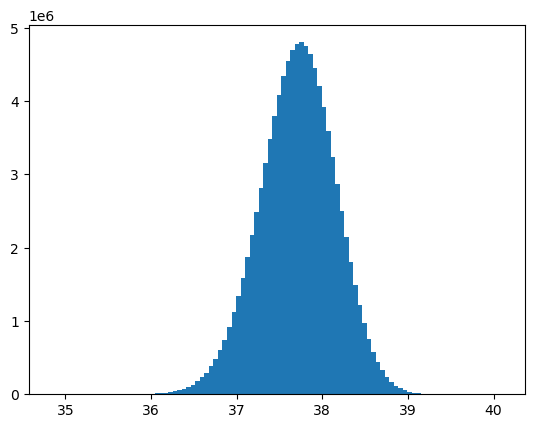

In [43]:
plt.hist(payoffs, bins=100);

In [44]:
f"Bachelier Price ${payoffs.max():.2f}"

# TODO get for SPY

'Bachelier Price $40.10'

In [41]:
payoffs

array([36.79164416, 38.0002765 , 38.36388031, ..., 37.29682439,
       37.35578771, 38.00107453])

payoffs


### 1.2 Static Replication of European Payoff Model
*using SABR model calibrated from Part 2*


##### Carr-Madan Static Replication formula
$$
V_0 = e^{-rT} h(F) + \int_{0}^{F} h''(K) P(K) \, dK + \int_{F}^{\infty} h''(K) C(K) \, dK
$$
#### 1.2.1 Calibrated SABR model
SPX: Exdate 20210115: alpha = 1.817, rho = -0.404, nu = 2.790

SPY: Exdate 20210115: alpha = 0.908, rho = -0.489, nu = 2.729
#### 1.2.2 Valuation
$$
S^{1/3}_T + 1.5 \times \log(S_T) + 10.0
$$
$$
h'(S_T) = \frac{1}{3} {S_T}^{-\frac{2}{3}} + 1.5 \frac{1}{S_T} \quad h''(S_T) = -\frac{2}{9} {S_T}^{-\frac{5}{3}} - 1.5 \frac{1}{{S_T}^2}
$$

$$

V_0 
= 
e^{-rT} \left[ K^{\frac{1}{3}} + 1.5 \times \log(K) + 10.0 \right]
    + \int_{0}^{F} \left( -\frac{2}{9} {K}^{-\frac{5}{3}} - 1.5 \frac{1}{{K}^2} \right) P(K) dK
        + \int_{F}^{\infty} \left( -\frac{2}{9} {K}^{-\frac{5}{3}} - 1.5 \frac{1}{{K}^2} \right) C(K) dK

$$



In [16]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesPut(S, K, r, sigma, T):
    return BlackScholesCall(S, K, r, sigma, T) - S + K*np.exp(-r*T)

def SABRCall(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesCall(S, K, r, sabr_vol, T)


def SABRPut(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesPut(S, K, r, sabr_vol, T)

def h_double_prime(K):
    h_pp = -2 / 9*K**(-5/3) - 1.5 / (K**2)
    return h_pp

def sabrcallintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for call side
    """
    price = SABRCall(S, K, r, alpha, beta, rho, nu, T) * h_double_prime(K)
    return price


def sabrputintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for put side
    """
    price = SABRPut(S, K, r, alpha, beta, rho, nu, T) * h_double_prime(K)
    return price


S = S_spx
alpha = dict_spx['alpha']
rho = dict_spx['rho']
nu = dict_spx['nu']
F = dict_spx['F']
I_put = quad(lambda x: sabrputintegrand(x, S, r, T, alpha, beta, rho, nu), 1e-6, F)
I_call = quad(lambda x: sabrcallintegrand(x, S, r, T, alpha, beta, rho, nu), F, 5000)
E_v = np.exp(-r*T) * (S**(1/3) + 1.5 * np.log(S) + 10) + I_put + I_call
print('The expected replicated price is: %.2f' % E_v[0])



The expected replicated price is: 36.77


In [14]:
dict_spx

{'F': 3756.2441250350075, 'K': 3660, 'alpha': 1.817, 'rho': -0.404, 'nu': 2.79}


## 2. Variance Swap
### 2.1 Black-Scholes Model
#### 2.1.1 $\sigma$ used
#### 2.1.2 Valuation

### 2.2 Bachelier Model
#### 2.2.1 $\sigma$ used
#### 2.2.2 Valuation

### 2.2 Static Replication of European Payoff Model
*using SABR model calibrated from Part 2*
#### 2.2.1 Calibrated SABR model
#### 2.2.2 Valuation